# Project Title: 
# Identify Health Care Professionals Using Transfer Learning on a Pre-trained Convolutional Neural Network (Resnet18)

Author: Kelvin Tham Kum Hong 

Dated: 25 Feb 2018

## Aim

TODO: Start narrating project

## Methodology: Transfer Learning Workflow (Using PyTorch)

We will do the following steps in order:
1. Loading and normalizing data (image set)
2. Create a general function to train a model
3. Create a generic function to display predictions for a few images

Using ConvNet as fixed feature extractor (achieved 100% accuracy on validation set of 45 images in 22mins): Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

#### Importing Libraries

In [1]:
# Basics
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.misc import toimage
import sklearn
import time
import os
import copy
import PIL
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
from torch import Tensor
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.model_zoo import load_url
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
plt.ion() # Interactive mode
%matplotlib inline

In [2]:
# Check library versions
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scipy: {}'.format(scipy.__version__))
print('pytorch: {}'.format(torch.__version__))
print('torchvision: {}'.format(torchvision.__version__))

pandas: 0.21.1
numpy: 1.12.1
matplotlib: 2.1.1
seaborn: 0.8.1
scipy: 1.0.0
pytorch: 0.3.0.post4
torchvision: 0.2.0


### 1. Analyze and Prepare Data (Image Set)

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([transforms.Resize(224), transforms.RandomCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

data_dir = 'data/HCW'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [4]:
print(dataset_sizes, class_names)
print(image_datasets)

{'train': 437, 'val': 97} ['doctor', 'nurse', 'patient']
{'train': <torchvision.datasets.folder.ImageFolder object at 0x11f591828>, 'val': <torchvision.datasets.folder.ImageFolder object at 0x11216ff60>}


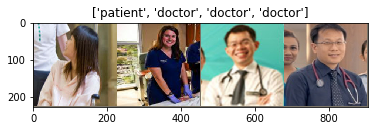

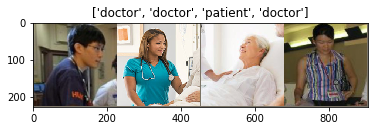

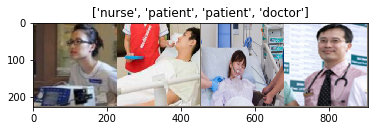

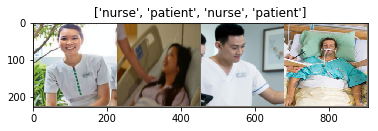

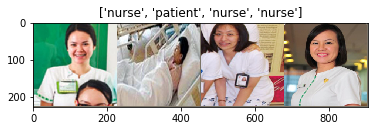

In [5]:
# Show some training images
def imshow(inp, title=None):
    '''Imshow for Tensor'''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

for i in range(5):
    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))

    # Make a grid of training data
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])
    i += 1

### 2. Generic function to train a model

In [6]:
Epochs = []
Training = []
Validation = []
Tr_loss = []
Valid_loss = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        Epochs.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # Get the inputs
                inputs, labels = data

                # Wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward + Optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'train':
                Training.append(epoch_acc*100)
                Tr_loss.append(epoch_loss)
            else:
                Validation.append(epoch_acc*100)
                Valid_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy and save the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "HCW_wts")
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 3. ConvNet as fixed feature extractor (Define model, loss function, optimizer and train only the last layer)

#### 3.1 Train model: PDSA 1

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)
#model_conv.load_state_dict(torch.load("HCW_wts"))
print(model_conv.fc)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optmized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Linear(in_features=512, out_features=3)


In [25]:
# LR PDSA #1
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.8526 Acc: 0.6178
val Loss: 0.4620 Acc: 0.7938

Epoch 2/25
----------
train Loss: 0.7016 Acc: 0.7025
val Loss: 0.3769 Acc: 0.8454

Epoch 3/25
----------
train Loss: 0.7012 Acc: 0.7254
val Loss: 0.3296 Acc: 0.8557

Epoch 4/25
----------
train Loss: 0.6674 Acc: 0.7231
val Loss: 0.3471 Acc: 0.8660

Epoch 5/25
----------
train Loss: 0.5621 Acc: 0.7849
val Loss: 0.3355 Acc: 0.8660

Epoch 6/25
----------
train Loss: 0.5764 Acc: 0.7735
val Loss: 0.4101 Acc: 0.8660

Epoch 7/25
----------
train Loss: 0.6393 Acc: 0.7551
val Loss: 0.3006 Acc: 0.8557

Epoch 8/25
----------
train Loss: 0.4887 Acc: 0.8032
val Loss: 0.2533 Acc: 0.8866

Epoch 9/25
----------
train Loss: 0.4319 Acc: 0.8307
val Loss: 0.3230 Acc: 0.8866

Epoch 10/25
----------
train Loss: 0.5038 Acc: 0.8101
val Loss: 0.2484 Acc: 0.8866

Epoch 11/25
----------
train Loss: 0.3962 Acc: 0.8444
val Loss: 0.3169 Acc: 0.8763

Epoch 12/25
----------
train Loss: 0.3963 Acc: 0.8330
val Loss: 0.2851 Acc: 0.8866

E

In [11]:
# Plot training, validation accuracy graph vs epoch runs
def plot_training(Epochs, Training, Validation):    
    plt.figure(figsize=(12,6))
    plt.plot(Epochs, Training, label='Training')
    plt.plot(Epochs, Validation, label='Validation')
    plt.title("SGD Training and Validation Accuracy, Lr=0.001, Mo=0.9, Decay=7", fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.ylim(0,100)
    plt.legend(loc='best')
    plt.show()

In [12]:
# Plot training, validation loss graph vs epoch runs
def plot_loss(Epochs, Tr_loss, Valid_loss):    
    plt.figure(figsize=(12,6))
    plt.plot(Epochs, Tr_loss, label='Training')
    plt.plot(Epochs, Valid_loss, label='Validation')
    plt.title("SGD Training and Validation Loss, Lr=0.001, Mo=0.9, Decay=7", fontsize=20)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

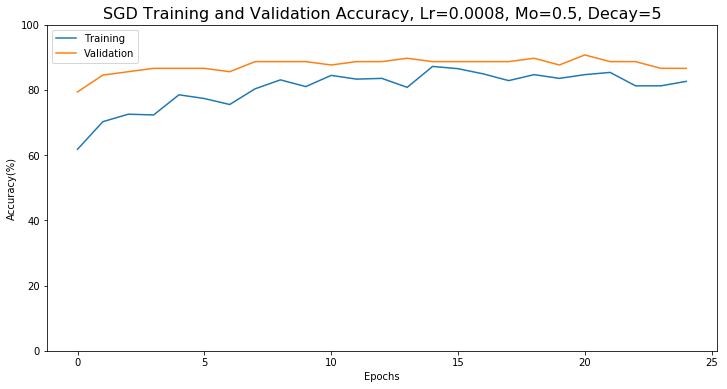

In [26]:
plot_training(Epochs, Training, Validation)

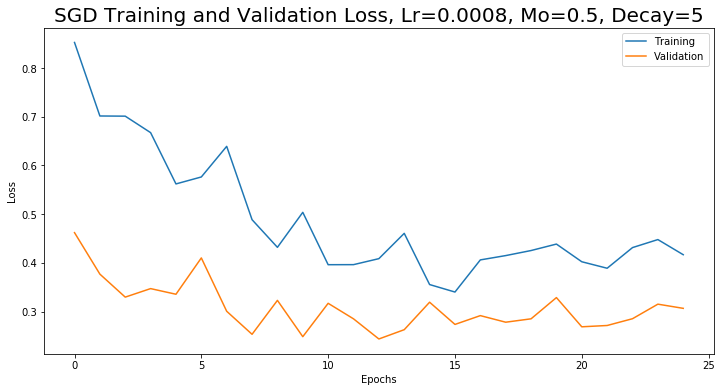

In [27]:
plot_loss(Epochs, Tr_loss, Valid_loss)

#### 3.2 Train model: PDSA 2

In [8]:
# Fine-tuning hyper-parameters
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)
model_conv.load_state_dict(torch.load("HCW_wts"))
print(model_conv.fc)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optmized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0008, momentum=0.5)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

Linear(in_features=512, out_features=3)


In [10]:
# LR PDSA #2
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.9404 Acc: 0.5469
val Loss: 0.7534 Acc: 0.7010

Epoch 2/25
----------
train Loss: 0.8024 Acc: 0.6590
val Loss: 0.6779 Acc: 0.7423

Epoch 3/25
----------
train Loss: 0.7646 Acc: 0.6590
val Loss: 0.5756 Acc: 0.7526

Epoch 4/25
----------
train Loss: 0.6813 Acc: 0.7437
val Loss: 0.4937 Acc: 0.8557

Epoch 5/25
----------
train Loss: 0.6668 Acc: 0.7300
val Loss: 0.4727 Acc: 0.8557

Epoch 6/25
----------
train Loss: 0.6332 Acc: 0.7483
val Loss: 0.4790 Acc: 0.8247

Epoch 7/25
----------
train Loss: 0.6685 Acc: 0.7277
val Loss: 0.4683 Acc: 0.8041

Epoch 8/25
----------
train Loss: 0.6395 Acc: 0.7346
val Loss: 0.4627 Acc: 0.8763

Epoch 9/25
----------
train Loss: 0.6311 Acc: 0.7574
val Loss: 0.4642 Acc: 0.8660

Epoch 10/25
----------
train Loss: 0.5720 Acc: 0.7895
val Loss: 0.4582 Acc: 0.8660

Epoch 11/25
----------
train Loss: 0.6098 Acc: 0.7643
val Loss: 0.4623 Acc: 0.8351

Epoch 12/25
----------
train Loss: 0.6227 Acc: 0.7506
val Loss: 0.4774 Acc: 0.8557

E

In [11]:
# Plot training, validation accuracy graph vs epoch runs
def plot_training(Epochs, Training, Validation):    
    plt.figure(figsize=(12,6))
    plt.plot(Epochs, Training, label='Training')
    plt.plot(Epochs, Validation, label='Validation')
    plt.title("SGD Training and Validation Accuracy, Lr=0.0008, Mo=0.5, Decay=5", fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.ylim(0,100)
    plt.legend(loc='best')
    plt.show()

In [12]:
# Plot training, validation loss graph vs epoch runs
def plot_loss(Epochs, Tr_loss, Valid_loss):    
    plt.figure(figsize=(12,6))
    plt.plot(Epochs, Tr_loss, label='Training')
    plt.plot(Epochs, Valid_loss, label='Validation')
    plt.title("SGD Training and Validation Loss, Lr=0.0008, Mo=0.5, Decay=5", fontsize=20)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

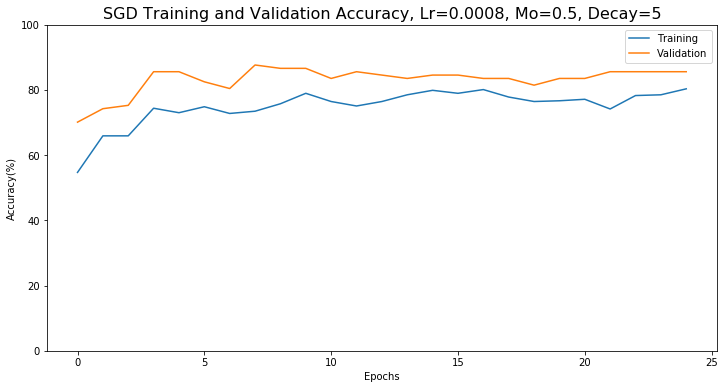

In [13]:
plot_training(Epochs, Training, Validation)

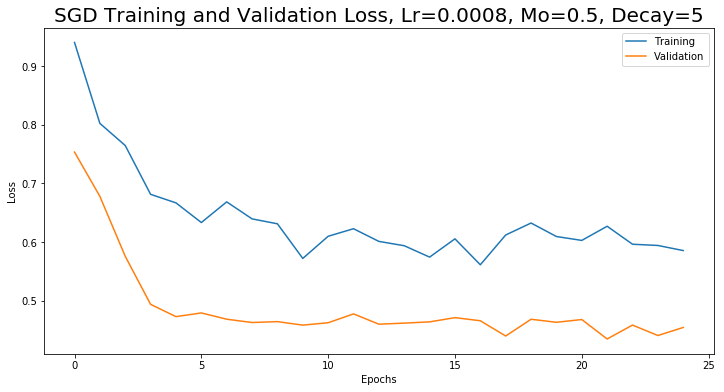

In [14]:
plot_loss(Epochs, Tr_loss, Valid_loss)

### 4. Analysis of Predictions (pre-finetune)

In [9]:
import itertools

label = []
predictions = []
merged_probs = []
images = []

for i, data in enumerate(dataloaders['val']):
    inputs, labels = data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
        
    outputs = model_conv(inputs)
    # Activation and prediction for each image 
    _, preds = torch.max(outputs.data, 1)
    
    # Extract labels into a list
    labels = labels.data.cpu().numpy()
    label.append(labels)
    merged_labels = np.array(list(itertools.chain(*label)))
    
    # Extract predictions into a list
    preds = preds.numpy()
    predictions.append(preds)
    merged_preds = np.array(list(itertools.chain(*predictions)))
                           
    # Extract probabilities into a list
    x = torch.nn.functional.softmax(outputs)
    probs = x.data.cpu().numpy()
    for batch in probs:
        merged_probs.append(max(batch))
    
    # Extract dataset of images in Tensor format
    inputs = inputs.data.cpu().numpy()
    images.append(inputs)
    merged_ds = np.array(list(itertools.chain(*images)))

In [10]:
# Returns indices of 4 random filtered values from list
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((merged_preds == merged_labels) == is_correct)

In [11]:
from os import listdir
from os.path import isfile, join

def load_img_id(ds, idx): return np.array(toimage(ds[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None, axis=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        ax = f.add_subplot(rows, len(ims)//rows, i+1)
        #ax.axis('Off')
        if titles is not None: ax.set_title(titles[i], fontsize=16)
        if axis is not None: ax.set_xlabel("Pred:{}".format(class_names[axis[i]]), fontsize=16)
        plt.imshow(ims[i])

In [12]:
def plot_val_with_title(idxs, title):
    print(title)
    imgs = np.stack([load_img_id(merged_ds,x) for x in idxs])
    title_probs = [merged_probs[x] for x in idxs]
    title_preds = [merged_preds[x] for x in idxs]
    return plots(imgs, rows=1, titles=title_probs, axis=title_preds, figsize=(16,8))

In [13]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*np.array(merged_probs)[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1
    return most_by_mask(((merged_preds == merged_labels)==is_correct) & (merged_labels == y), mult)

Correctly classified (random)


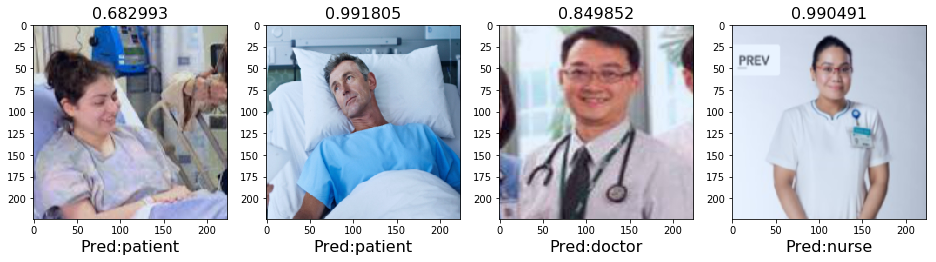

In [14]:
plot_val_with_title(rand_by_correct(True), "Correctly classified (random)")

Incorrectly classified (random)


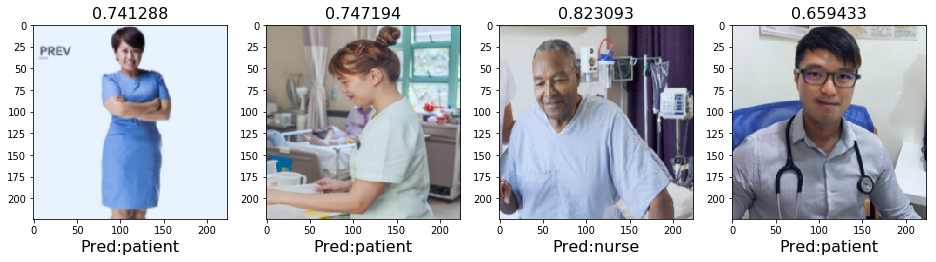

In [15]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified (random)")

Most correct doctor


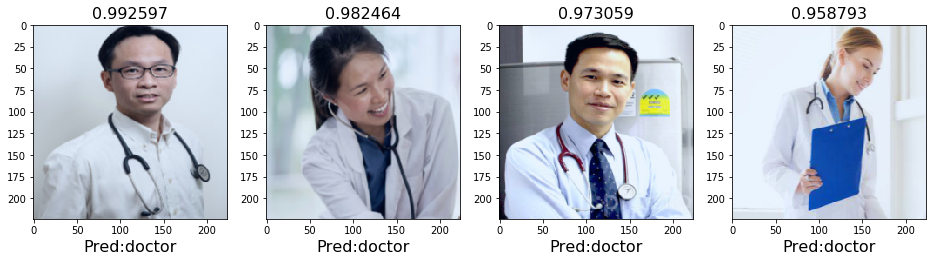

In [16]:
plot_val_with_title(most_by_correct(0, True), 'Most correct doctor')

Most incorrect doctor


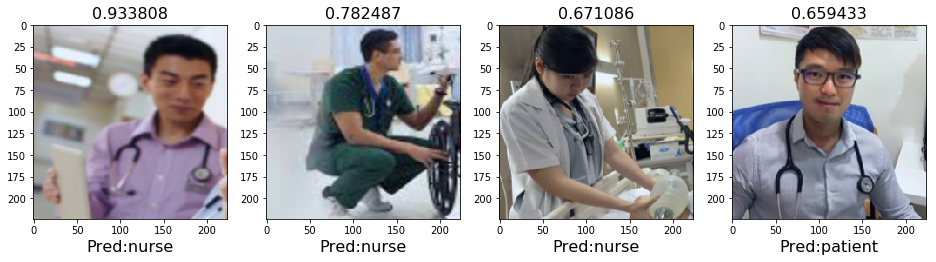

In [17]:
plot_val_with_title(most_by_correct(0, False), 'Most incorrect doctor')

Most correct nurse


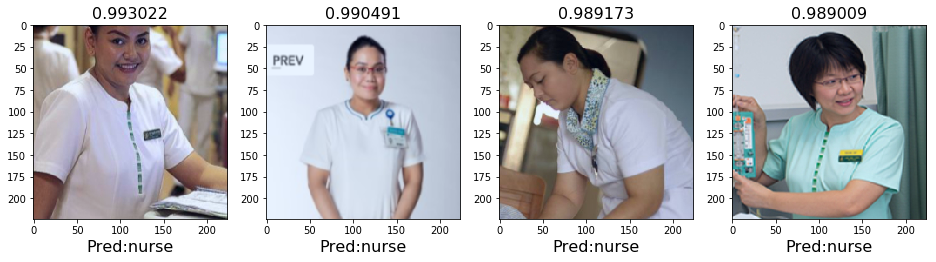

In [18]:
plot_val_with_title(most_by_correct(1, True), 'Most correct nurse')

Most incorrect nurse


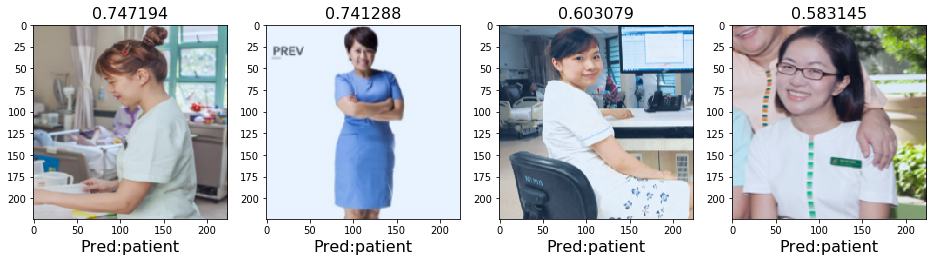

In [19]:
plot_val_with_title(most_by_correct(1, False), 'Most incorrect nurse')

Most correct patient


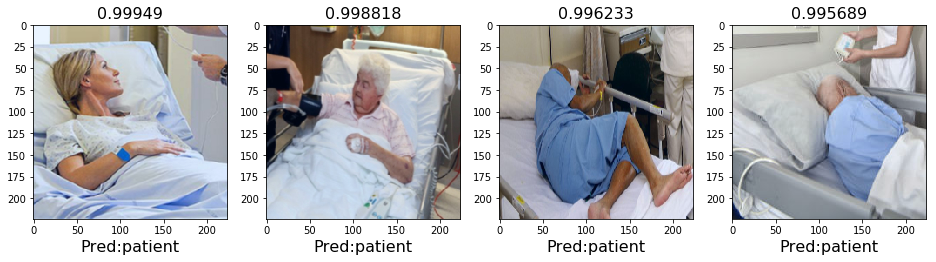

In [20]:
plot_val_with_title(most_by_correct(2, True), 'Most correct patient')

Most incorrect patient


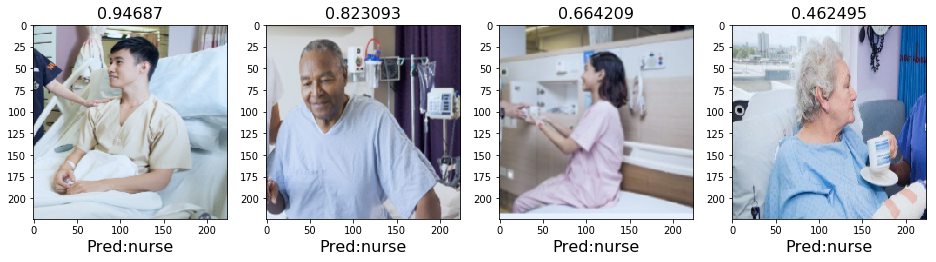

In [21]:
plot_val_with_title(most_by_correct(2, False), 'Most incorrect patient')

Most uncertain predictions


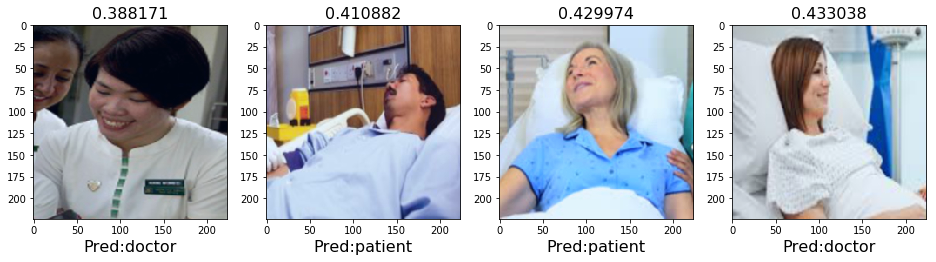

In [22]:
most_uncertain = np.argsort(np.array(merged_probs))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [23]:
# TODO: Compare acc against training data size - Doc(95), nurse(171), patients(171)
doctor_preds = ((merged_preds == merged_labels)==True) & (merged_labels == 0)
nurse_preds = ((merged_preds == merged_labels)==True) & (merged_labels == 1)
patient_preds = ((merged_preds == merged_labels)==True) & (merged_labels == 2)

doctor_acc = (np.count_nonzero(doctor_preds == True))/22 * 100 
nurse_acc = (np.count_nonzero(nurse_preds == True))/36 * 100 
patient_acc = (np.count_nonzero(patient_preds == True))/39 * 100 
                                                           
print("Doctor Acc:{:.2f}%\nNurse Acc:{:.2f}%\nPatient Acc:{:.2f}%".format(doctor_acc, nurse_acc, patient_acc))

Doctor Acc:72.73%
Nurse Acc:80.56%
Patient Acc:84.62%


Text(0.5,1,'Prediction Performance on Validation Set(by Class)')

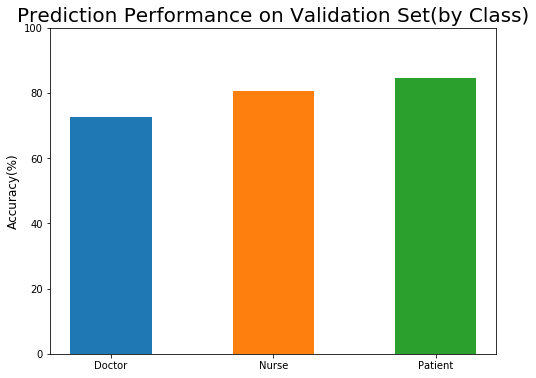

In [24]:
plt.figure(figsize=(8,6))
plt.bar('Doctor', height=doctor_acc, width=0.5)
plt.bar('Nurse', height=nurse_acc, width=0.5)
plt.bar('Patient', height=patient_acc, width=0.5)
plt.ylabel('Accuracy(%)', fontsize=12)
plt.ylim(0,100)
plt.title('Prediction Performance on Validation Set(by Class)', fontsize=20)

### 5. Final Layer Visualisation

In [133]:
model_conv

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [25]:
# TODO: Visualisation of last FC
?torchvis

Object `torchvis` not found.
